In [1]:
version = 9

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [4]:
records_iq = pd.read_csv(
    './generated/1-features-iq.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()
records_sj = pd.read_csv(
    './generated/1-features-sj.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()

In [5]:
labels_iq = pd.read_csv(
    './generated/1-labels-train-iq.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)
labels_sj = pd.read_csv(
    './generated/1-labels-train-sj.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)

In [6]:
def predict_for(records, labels, ntrain, lencycle, features=['station_temp']):
    lr_seasonal = LinearRegression()
    weeks = pd.get_dummies(records['weekofyear'], prefix='w')
    train_weeks = weeks[:ntrain].reset_index().drop('week_start_date', axis=1)
    test_weeks = weeks[ntrain:].reset_index().drop('week_start_date', axis=1)
    train_cases = labels[['total_cases']].reset_index().drop('week_start_date', axis=1)

    lr_seasonal.fit(train_weeks, train_cases)
    seasonal = pd.Series(
        lr_seasonal.predict(train_weeks).flatten()).rolling(5, min_periods=1, center=True).mean()
    remainder = train_cases.total_cases - seasonal

    trend = records[features].reset_index().drop('week_start_date', axis=1).rolling(lencycle).mean()
    train_trend = trend[lencycle:ntrain]
    test_trend = trend[ntrain:]
    train_remainder = remainder[lencycle:]

    lr_trend = LinearRegression()
    lr_trend.fit(train_trend, train_remainder)
    
    train_pred_trend = pd.Series(lr_trend.predict(train_trend).flatten())
    print('mae: ' + str(mean_absolute_error(y_pred=train_pred_trend.values + seasonal[lencycle:].values,
                    y_true=train_cases['total_cases'][lencycle:].values)))

    pred_seasonal = pd.Series(lr_seasonal.predict(test_weeks).flatten())
    pred_trend = pd.Series(lr_trend.predict(test_trend).flatten())

    pred = (pred_trend + pred_seasonal).rolling(5, min_periods=1, center=True).mean()

    return pred

In [7]:
records_iq.columns

Index(['weekofyear', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
       'station_precip_mm', 'ndvi', 'station_temp'],
      dtype='object')

In [8]:
records_sj.columns

Index(['weekofyear', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
       'station_precip_mm', 'ndvi_n', 'ndvi_s', 'reanalysis_temp',
       'station_temp'],
      dtype='object')

In [9]:
# pred_iq = predict_for(records_iq, labels_iq, 520, 52, ['precipitation_amt_mm', 'reanalysis_air_temp_k',
#        'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
#        'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
#        'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
#        'station_precip_mm', 'ndvi', 'station_temp'])
# pred_sj = predict_for(records_sj, labels_sj, 936, 52, ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
#        'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
#        'station_precip_mm', 'ndvi_n', 'ndvi_s', 'reanalysis_temp',
#        'station_temp'])

pred_iq = predict_for(records_iq, labels_iq, 520, 53, [
    'reanalysis_precip_amt_kg_per_m2',
    'reanalysis_relative_humidity_percent', 
    'station_temp'])
pred_sj = predict_for(records_sj, labels_sj, 936, 53, [
    'reanalysis_precip_amt_kg_per_m2',
    'reanalysis_relative_humidity_percent',
    'station_temp'])

mae: 6.224245381445524
mae: 25.265538836823143


In [10]:
pred = pd.concat([pred_sj, pred_iq], ignore_index=True).round().clip_lower(0)

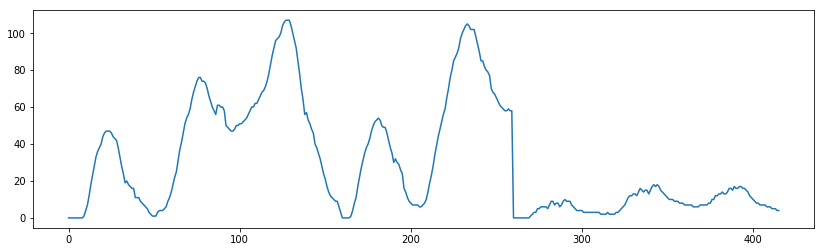

In [11]:
pred.plot(figsize=(14, 4))

In [12]:
pred.to_csv('./generated/2b-seasonal-trend-prediction-' + str(version) + '.csv', index=False)